# Control of Two-way Coupled Fluid Systems with Differentiable Solvers


This notebook shows how to train a neural network in an unsupervised way in order for it to act as a controller in an environment with two way coupling.

The source code is provided [here](https://github.com/brenerrr/PhiFlow) in the **two_way_coupling branch**.

First of all, we need to prepare the current environment by downloading and installing all necessary packages to run the code.

In [1]:
#%cd /content/

# warning - needs python 3.7!

#!rm -rf ./two-way-coupled-control
#!git clone https://github.com/tum-pbs/two-way-coupled-control.git
#%cd two-way-coupled-control

#!pip install torch torchvision torchaudio
#&> /dev/null # Supressing output
#!pip install . ./
#&> /dev/null  # Supressing output

# Inputs

All inputs that control training and simulation are set below. The default values below are the ones used to train a controller for a 2 degrees of freedom environment (disc).

In [2]:
%%capture
from math import ceil
from neural_control.neural_networks.NeuralController import NeuralController
from neural_control.misc.misc_funcs import *
import argparse
from time import time
import json

# ----------------------------------------------
# -------------------- Inputs ------------------
# ----------------------------------------------
seed = 100
# paths assume we're in two-way-coupled-control/
export_path = "./storage/diff_2dof/"
simulation_path = "./storage/ics/training_2dof/" # Path to IC simulation
n_timesteps = 1000 # Number of timesteps per simulation
lr_half_life = 201 # Amount of iterations necessary for learning rate dropping by half
n_iterations = 1001 # Number of weights updates
n_before_backprop = 16 # Number of timesteps before updating weights
translation_only = True # 2 DoF
past_window = 2 # Number of past states that are sent to the network
hyperparams = { # Loss hyperparameters
    "spatial": 15,
    "velocity": 5,
    "force": 0.1,
    "delta_force": 5.0,
    "angle": 0,
    "torque": 0,
    "ang_velocity": 0,
    "delta_torque": 0,
    "proximity": 0.1
}
learning_rate = 0.01
max_acc = 1
# -------------------- Less critical inputs --------------------
nn_vars = [
    "obs_vx",
    "obs_vy",
    "error_x",
    "error_y",
    "control_force_x",
    "control_force_y"
]
device_str = "CPU"
max_ang_acc = 0
architecture = "fc_only"
export_stride = 50
model_export_stride = 100
optimizer_str = "AdamW"
destinations_margins = np.array([20,20])
destinations_zone_growrate = 0.33
# Simulation parameters
re = 1000
obs_density = 0.15
reference_velocity = 1
reference_length = 5
inflow_on = False
dt = 0.1
obs_type = "disc"
obs_width = 5
obs_height = 5
time_step_scheme = "RK2"
domain_size = np.array([80,80])
obs_xy = [40,40]
sponge_intensity = 0.01
sponge_size = [5,5,5,5]
obs_mass = 11.780972450961725
obs_inertia = 49.087385212340514
export_vars = [
    "pressure","vx","vy","obs_mask","obs_xy","obs_vx","obs_vy",
    "control_force_x","control_force_y","fluid_force_x","fluid_force_y",
    "reference_x","reference_y","loss","loss_velocity","loss_spatial","error_x",
    "error_y","loss_ang","loss_ang_vel","fluid_torque","vorticity","cfl"]



# Pre processing

With all inputs set, the simulation and training classes can be initialized as well as generating the objectives that will be used during training.

In [3]:
TORCH_BACKEND.set_default_device("CPU")
device = torch.device("cpu")
# ----------------------------------------------
# ---------------- Setup simulation ------------
# ----------------------------------------------
sim = TwoWayCouplingSimulation(device, translation_only)
sim.set_initial_conditions(obs_type, obs_width, obs_height, path=simulation_path)
# Reference variables used to map physical values to network inputs/outputs
ref_vars = dict(
    velocity=reference_velocity,
    length=reference_length,
    force=obs_mass * max_acc,
    angle=PI,
    torque=obs_inertia * max_ang_acc,
    time=obs_width / reference_velocity,
    ang_velocity=reference_velocity / obs_width
)
destinations_zone_size = domain_size - destinations_margins * 2

# ----------------------------------------------
# ---------------- Setup training --------------
# ----------------------------------------------
n_features = defaultdict(lambda: 1)
n_past_features = np.sum([n_features[var] for var in nn_vars])
n_present_features = np.sum([n_features[var] for var in nn_vars if "control" not in var])
training_dt = dt
model = NeuralController(
    f"{architecture}{past_window}",
    2 if translation_only else 3,
    n_present_features,
    n_past_features,
    past_window)
torch.manual_seed(seed + 1)
model.to(device)
print("\n\n Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n Total amount of trainable parameters: {total_params}")
optimizer_func = getattr(torch.optim, optimizer_str)
optimizer = optimizer_func(model.parameters(), lr=learning_rate)
decay = np.exp(np.log(0.5) / lr_half_life)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay)

# ----------------------------------------------
# --------------- Setup objectives -------------
# ----------------------------------------------
first_case = 0
os.makedirs( f"{export_path}", exist_ok=True)
torch.save(model.state_dict(),f"{export_path}/initial_model_{first_case}.pt")
# Number of simulations necessary to achieve desired number of iterations
n_simulations = n_iterations / (n_timesteps / n_before_backprop)
# Add double the necessary  amount just in case some exhibit early termination
n_simulations = ceil(n_simulations) * 2
# Create objectives
torch.manual_seed(seed + 2)
xy = torch.rand(2, n_simulations)
ang = torch.rand(n_simulations)
for case in range(n_simulations):
    growrate = np.min((destinations_zone_growrate * (case + 1), 1.))
    margins = (domain_size - destinations_zone_size * growrate) / 2
    xy[:, case] = xy[:, case] * destinations_zone_size * growrate + margins
    ang[case] = ((ang[case] * 2 * PI - PI) * growrate)
# Save objectives
objective_xy = xy.numpy().T.tolist()
objective_ang = ang.numpy().tolist()
objective_xy = xy.to(device)
objective_ang = ang.to(device)

# Save inputs to json file
inp = {
    "export_vars" : export_vars,
    "translation_only" : translation_only,
    "architecture" : architecture,
    "past_window" : 2,
    "export_stride" : export_stride,
    "max_acc" : max_acc,
    "max_ang_acc": max_ang_acc,
    "device" : "CPU",
    "bypass_tanh" : False,
    "nn_vars" : nn_vars,
    "training_dt" : dt,
    "n_present_features": int(n_present_features),
    "n_past_features" : int(n_past_features),
    "ref_vars": ref_vars,
    "unsupervised" : {
        "simulation_path": simulation_path,
        "destinations_zone_growrate": destinations_zone_growrate,
        "n_timesteps": n_timesteps,
        "lr_half_life": lr_half_life,
        "n_iterations": n_iterations,
        "learning_rate": learning_rate,
        "n_before_backprop": n_before_backprop,
        "model_export_stride": model_export_stride,
        "optimizer": optimizer_str,
        "destinations_margins": destinations_margins.tolist(),
        "hyperparams": hyperparams,
    }
}
with open(f'{export_path}/inputs.json', 'w') as f:
    json.dump(inp, f, indent=4)

Loading default value for obs_vx
Loading default value for obs_vy
Loading default value for obs_ang
Loading default value for obs_ang_vel
Did not found data of second obstacle


 Model's state_dict:
layers.0.weight 	 torch.Size([38, 16])
layers.0.bias 	 torch.Size([38])
layers.1.weight 	 torch.Size([38, 38])
layers.1.bias 	 torch.Size([38])
layers.2.weight 	 torch.Size([2, 38])
layers.2.bias 	 torch.Size([2])

 Total amount of trainable parameters: 2206


# Training

The network is trained by minimizing the following loss function

$$L = O + V + E$$

$$O = \frac{\beta_{xy}}{l}\sum_{n=0}^{l-1}\|e_{xy}^n\|^2 + \frac{\beta_{\alpha}}{l}\sum_{n=0}^{l-1} \|e_{\alpha}^n\|^2$$

$$V = \frac{\beta_{\dot{x}}}{l}\sum_{n=0}^{l-1}\frac{\|\dot{x}^n\|^2}{\beta_{prox}\|e_{xy}^n\|^2 + 1} + \frac{\beta_{\dot{\alpha}}}{l}\sum_{n=0}^{l-1}\frac{\|\dot{\alpha}^n\|^2}{\beta_{prox}\|e_{\alpha}^n\|^2 + 1}$$

$$ E = \frac{\beta_F}{l}\sum_{n=0}^{l-1} \|F_c^n\|^2
    + \frac{\beta_T}{l}\sum_{n=0}^{l-1} \|T_c^n\|^2 +
      \frac{\beta_{\Delta F}}{l}\sum_{n=0}^{l-1} \|F_c^n-F_c^{n-1}\|^2
    + \frac{\beta_{\Delta T}}{l}\sum_{n=0}^{l-1} \|T_c^n-T_c^{n-1}\|^2 $$

where $\dot{x}$
and $\dot{\alpha}$
represent velocities,
$e$ errors,
and $F_c$
and $T_c$
control efforts. $\beta$ are hyperparameters that weigh the contribution of each term.

Intermediate models are saved during training before all iterations are performed as *trained_model_####.pt*, where #### is a model index.


<br>
<p align="center">
<img src="https://github.com/brenerrr/PhiFlow/blob/two_way_coupling/schematic.png?raw=true" height=250/>
<img src="https://raw.githubusercontent.com/brenerrr/PhiFlow/two_way_coupling/training_box.gif" width="250" height="250"/>
<figcaption align = "center"><b>A schematic of the differentiable solver training: Blue arrows represent the forward pass while red ones illustrate the flow of gradients. Importantly, the loss signal is backpropagated through l simulation steps to provide policy P with long-term feedback about the flow environment.</b></figcaption>
</p>
<br>



In [ ]:
last_time = time()
i_bp = 0
case = 0
while i_bp < n_iterations:
    # Setup case with default initial values
    sim.setup_world(
        re,
        domain_size,
        dt,
        obs_mass,
        obs_inertia,
        reference_velocity,
        sponge_intensity,
        sponge_size,
        inflow_on)
    # Variables initialization
    nn_inputs_past = torch.zeros((past_window, 1, n_past_features)).to(device)
    loss_inputs = defaultdict(lambda: torch.zeros((n_before_backprop, 1, 1)).to(device))
    if translation_only:
        control_effort = torch.zeros(2).to(device)
    else:
        control_effort = torch.zeros(3).to(device)
    last_control_force = torch.zeros(2).to(device)
    control_force_global = torch.zeros(2).to(device)
    control_force = torch.zeros(2).to(device)
    control_force2 = torch.zeros(2).to(device)
    control_torque = torch.zeros(1).to(device)
    last_control_torque = torch.zeros(1).to(device)
    loss = torch.zeros(1).to(device)
    loss_terms = defaultdict(lambda: 0)
    # Run simulation
    for i in range(0, n_timesteps + 1):
        # Check CFL in the first iterations due to possible numerical instabilities
        if case < 10:
            if math.max(math.abs(sim.velocity.values)) * sim.dt > 1.5:
                print("CFL too big. Resetting simulation")
                break
        sim.apply_forces(control_force_global * ref_vars['force'], control_torque * ref_vars['torque'])
        sim.advect()
        # In case body escapes domain
        if math.any(sim.obstacle.geometry.center > domain_size) or math.any(sim.obstacle.geometry.center < (0, 0)):
            print("Obstacle is out of bounds. Resetting simulation")
            break
        sim.make_incompressible()
        sim.calculate_fluid_forces()
        # Control
        nn_inputs_present, loss_inputs_present = extract_inputs(nn_vars, sim, objective_xy[:, case], objective_ang[case], ref_vars, translation_only)
        if i < past_window: last_backprop = i  # Wait to backprop until past inputs are cached
        else:
            control_effort = model(nn_inputs_present.view(1, -1), nn_inputs_past.view(1, -1))
            control_force = control_effort[0, :2]
            loss_inputs_present['d_control_force_x'], loss_inputs_present['d_control_force_y'] = (control_force - last_control_force)
            loss_inputs_present['control_force_x'], loss_inputs_present['control_force_y'] = control_force
            last_control_force = control_force
            if translation_only: control_force_global = control_force
            else:
                angle_tensor = -(sim.obstacle.geometry.angle - math.PI / 2.0).native()
                control_force_global = rotate(control_force, angle_tensor)  # Control force at global reference of frame (used for visualization only)
                # Additional inputs for loss
                control_torque = control_effort[0, -1:]
                d_control_torque = control_torque - last_control_torque
                last_control_torque = control_torque
                loss_inputs['d_control_torque'] = d_control_torque
                loss_inputs['control_torque'] = control_torque
            # Save quantities necessary for loss
            for key in loss_inputs_present:
                loss_inputs[key] = torch.cat((loss_inputs[key][1:, ...], loss_inputs_present[key].view(1, 1, 1)))
            # Update weights
            if (i - last_backprop == n_before_backprop):
                loss, loss_terms = calculate_loss(loss_inputs, hyperparams, translation_only)
                loss.backward()
                optimizer.step()
                i_bp += 1
                # Export model
                if i_bp % model_export_stride == 0:
                    model_id = int(i_bp / model_export_stride)
                    print(f"Saving model {model_id}")
                    torch.save(model.state_dict(), os.path.abspath(f"{export_path}/trained_model_{model_id:04d}.pt"))
                if i_bp == n_iterations: break
                lr_scheduler.step()  # Decay learning rate after backprop
                optimizer.zero_grad()
                # Reset graph
                control_force = None
                loss_inputs = {key: value.detach() for key, value in loss_inputs.items()}
                control_effort = control_effort.detach()
                control_torque = control_torque.detach()
                last_control_force = last_control_force.detach()
                last_control_torque = last_control_torque.detach()
                nn_inputs_present = nn_inputs_present.detach()
                nn_inputs_past = nn_inputs_past.detach()
                control_force_global = control_force_global.detach()
                sim.detach_variables()
                last_backprop = i
        nn_inputs_past = update_inputs(nn_inputs_past, nn_inputs_present, control_effort)

        # ----------------------------------------------
        # -------------------- Export ------------------
        # ----------------------------------------------
        if (i % export_stride != 0): continue
        sim.loss = loss.detach()
        for key, value in loss_terms.items():
            setattr(sim, f"loss_{key}", value.detach())
        sim.reference_x = objective_xy[0, case].detach()
        sim.reference_y = objective_xy[1, case].detach()
        sim.control_force_x, sim.control_force_y = control_force_global.detach() * ref_vars['force']
        sim.error_x = loss_inputs_present['error_x'].detach() * ref_vars['length']
        sim.error_y = loss_inputs_present['error_y'].detach() * ref_vars['length']
        if not translation_only:
            angle = -(sim.obstacle.geometry.angle - math.PI / 2.0).native().detach()
            sim.error_x, sim.error_y = rotate(torch.cat((sim.error_x, sim.error_y)), angle)
            sim.reference_ang = objective_ang[case].detach()
            sim.error_ang = loss_inputs_present['error_ang'].detach() * ref_vars['angle']
            sim.control_torque = control_torque.detach() * ref_vars['torque']
        sim.export_data(export_path, case, int(i / export_stride), export_vars, (case == 0 and i == 0))
        # Calculate how much time is left
        current_time = time()
        steps_left = (((n_simulations / 2 - 1) - (case + 1)) * n_timesteps + n_timesteps - (i + 1)) / export_stride
        time_left = steps_left * (current_time - last_time) / 3600
        last_time = current_time
        time_left_hours = int(time_left)
        time_left_minutes = int((time_left - time_left_hours) * 60)
        print(f"Time left: {time_left_hours:d}h {time_left_minutes:d} min")
        i += 1
    case += 1


# Testing

Although the network is trained in a simple environment with a quiescent flow as initial condition, it is able to handle more complex test scenarios. Here we will run a test with a source of lighter fluid on the bottom of the domain that rises due to buoyancy which creates challenging perturbations.

In [ ]:
!python ./neural_control/testing/generate_tests.py
!python ./neural_control/testing/test_networks.py ./storage/diff_2dof 10 2

# Metrics

After the test is done, the metrics of the network performance can be calculated and saved to a json file in *storage/diff_2dof/tests/test2_10/metrics.json*. The code below calculates the metrics and plots the error of different cases used in test 2.

Grouping frames of ./storage/diff_2dof
Done grouping frames for data
Now grouping frames for tests
Done grouping frames for tests

 Could not find error_ang_case 0000. Skipping...

 Could not find error_ang_case 0000. Skipping...

 Could not find error_ang_case 0000. Skipping...

 Could not find reference_ang_case 0000. Skipping...

 Could not find error_ang_case 0000. Skipping...

 Could not find reference_ang_case 0000. Skipping...
Done


Text(0.5, 0, 'Snapshot')

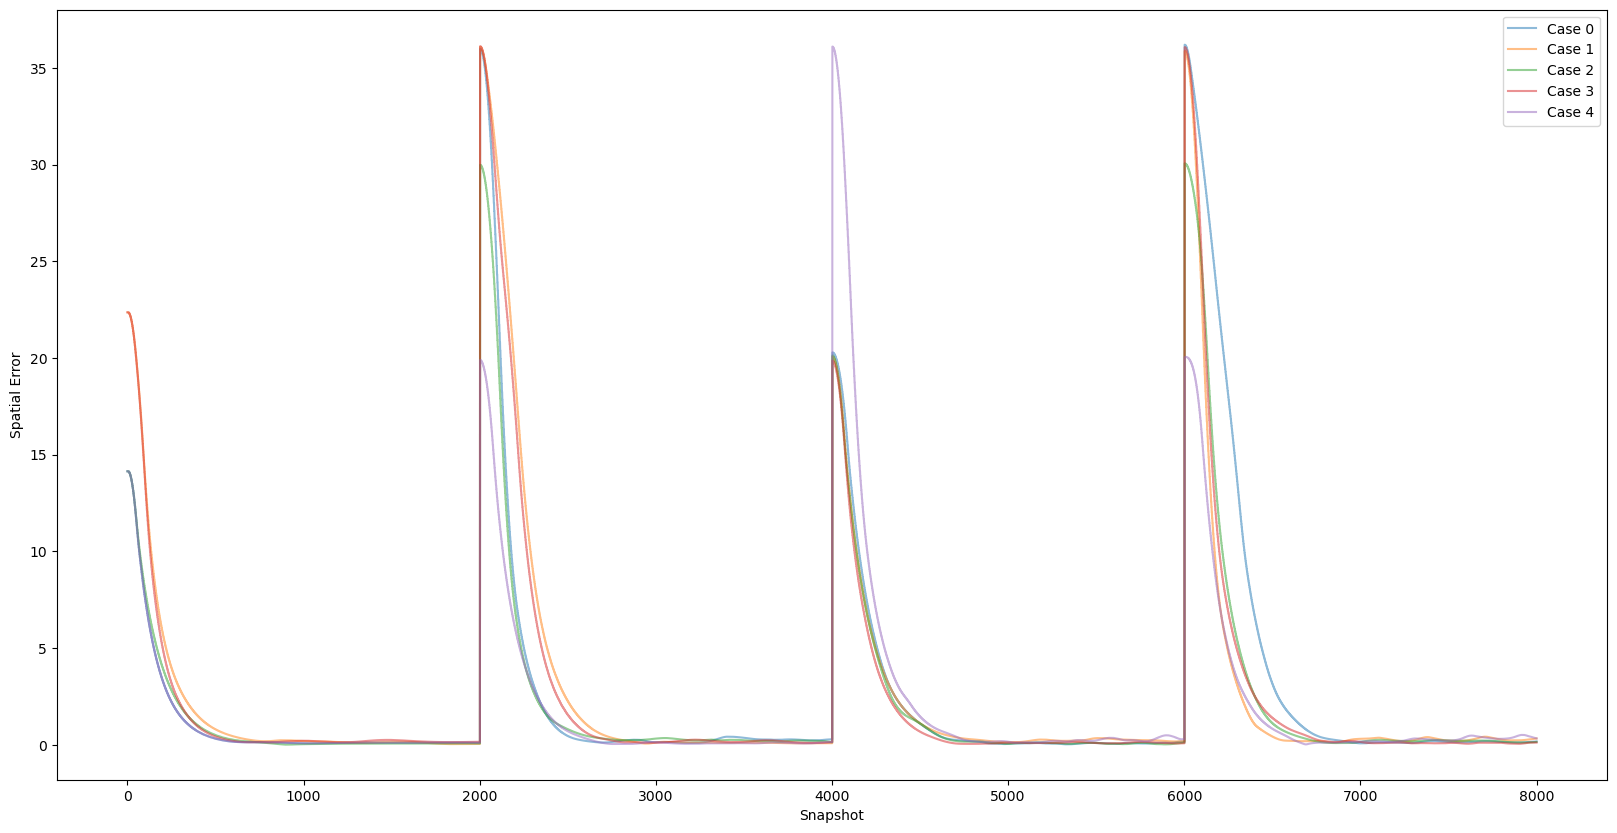

In [6]:
!python ./neural_control/misc/group_frames.py ./storage/diff_2dof
!python ./neural_control/misc/calculate_metrics.py ./storage/diff_2dof

# Plot spatial error of cases ran in test
import json
import numpy as np
import matplotlib.pyplot as plt

with open('./storage/diff_2dof/tests/test2_10/metrics.json') as f:
    data = json.load(f)

fig, ax = plt.subplots(1, 1, figsize=(20,10))
error_xy_all = np.array(data['error_xy_all'])
for i, error_xy in enumerate(error_xy_all):
    ax.plot(error_xy, label=f"Case {i}", alpha=0.5)
plt.legend()
plt.ylabel('Spatial Error')
plt.xlabel('Snapshot')


# Fields

It is also possible to plot the fields shown in the paper for specific snapshots. Below it is shown lighter fluid contours on timestep 1500.



 Ploting smoke from diff_2dof and test 2 


Treating simulation as translation only
1500
Created imshow figure with data from field 
neural_control/visualization/plot_fields.py:232: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(right=0.72)  # Test 2
Created imshow figure with data from mask 
Created plot figure with data from xy 
Created plot figure with data from xy_current 
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
Treating simulation as translation only
1500
Created imshow figure with data from field 
Created imshow figure with data from mask 
Created plot figure with data from xy 
Created plot figure with data from xy_current 
Treating simulation as translation only
1500
Created imshow figure with data from field 
Created imshow figure with data from mask 
Created plot figure with data from xy 
Created plot figure 

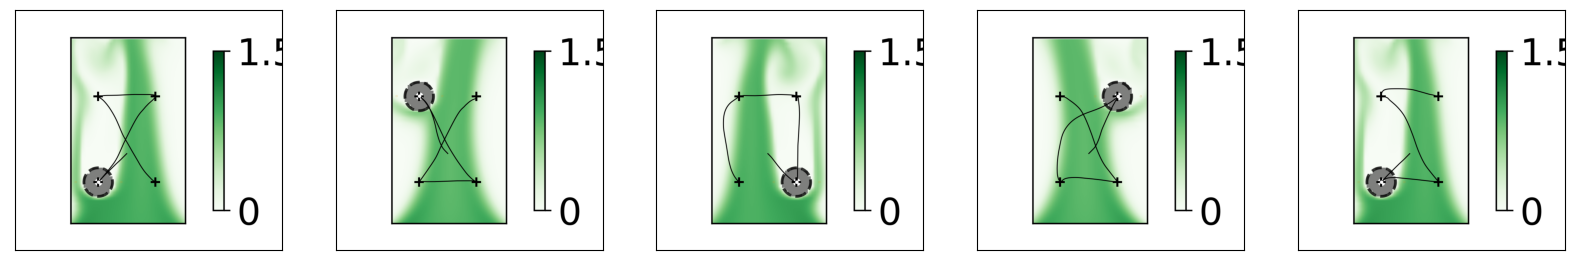

In [7]:
!python neural_control/visualization/plot_fields.py ./storage/ 2 1500 --folders diff_2dof --backend agg

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axs = plt.subplots(1,5, figsize=(20,10))

for i, ax in enumerate(axs):
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    img = mpimg.imread(f'./storage/figs/diff_2dof_smoke_test2_case000{i}_01500.png')
    ax.imshow(img)